In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [50]:
data = pd.read_csv('seasonally-adjusted-quarterly-us.csv')

In [51]:
data.head()

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%
2,1948Q3,3.767%
3,1948Q4,3.833%
4,1949Q1,4.667%


In [52]:
data.columns = ['year_quarter', 'unemployment_rate']

In [53]:
data.head()

,year_quarter,unemployment_rate
0,1948Q1,3.733%
1,1948Q2,3.667%
2,1948Q3,3.767%
3,1948Q4,3.833%
4,1949Q1,4.667%


In [54]:
data2 = data.copy()

In [55]:
data2.dropna(inplace=True)

In [56]:
data2["unemployment_rate"] = data["unemployment_rate"].str.replace("%", "").astype(float)

In [57]:
data.head()
print data.dtypes

year_quarter         object
unemployment_rate    object
dtype: object


In [58]:
data2["unemployment_rate"] = data["unemployment_rate"].str.strip("%").astype(float)

In [59]:
data2.head()

,year_quarter,unemployment_rate
0,1948Q1,3.733
1,1948Q2,3.667
2,1948Q3,3.767
3,1948Q4,3.833
4,1949Q1,4.667


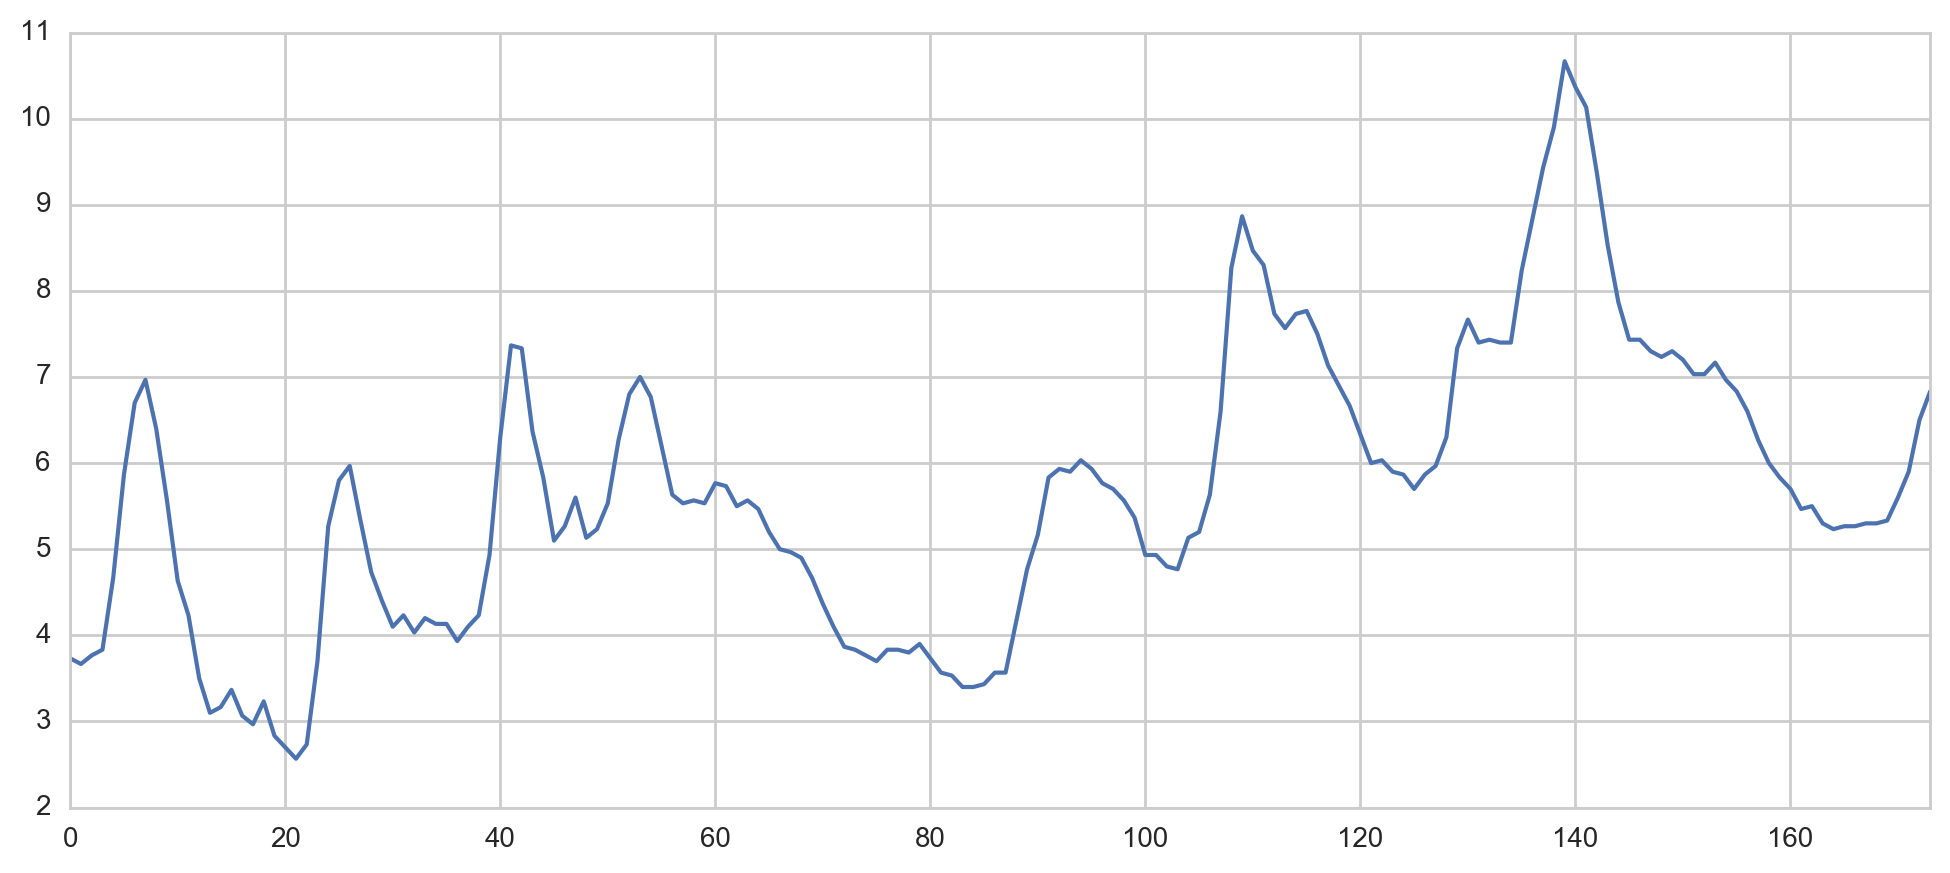

In [60]:
data2.unemployment_rate.plot(lw=1.5, figsize=(12,5))

In [61]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [64]:
urate = data2[['unemployment_rate']]
mms = MinMaxScaler()
urate = mms.fit_transform(urate)

In [66]:
urate.shape

(174, 1)

In [84]:
train, test = urate[:urate.shape[0]/2, :], urate[urate.shape[0]/2:, :]

In [69]:
train.shape, test.shape

((87, 1), (87, 1))

In [71]:
def create_XY(timeseries, lag=1):
    ts = timeseries.ravel()
    y = ts[lag:]
    X = []
    for i in range(lag):
        X.append(ts[i:len(y)+i])
    return np.array(X).T, y

### Create training and testing data for a lag of 1

In [107]:
urateX, urateY = create_XY(urate, lag=1)

In [130]:
urateX = urateX.reshape(len(urateX), 1)
urateY = urateY.reshape(len(urateY),1)

In [140]:
trainX, trainY = urateX[:urate.shape[0]/2, :], urateY[:urate.shape[0]/2,:]
testX, testY = urateX[urate.shape[0]/2:, :], urateY[urate.shape[0]/2:,:]

In [141]:
trainX.shape, trainY.shape

((87, 1), (87, 1))

In [142]:
testX.shape, testY.shape

((86, 1), (86, 1))

In [143]:
#reshaping to [samples, timesteps, features] format
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Constructing the Keras Model

In [144]:
model = Sequential()
model.add(LSTM(4, input_dim=1))
model.add(Dense(1))

### Fit the LSTM Model

In [145]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
2s - loss: 0.0789
Epoch 2/100
0s - loss: 0.0374
Epoch 3/100
0s - loss: 0.0239
Epoch 4/100
0s - loss: 0.0201
Epoch 5/100
0s - loss: 0.0188
Epoch 6/100
0s - loss: 0.0178
Epoch 7/100
0s - loss: 0.0166
Epoch 8/100
1s - loss: 0.0157
Epoch 9/100
0s - loss: 0.0149
Epoch 10/100
1s - loss: 0.0139
Epoch 11/100
0s - loss: 0.0129
Epoch 12/100
1s - loss: 0.0120
Epoch 13/100
1s - loss: 0.0112
Epoch 14/100
1s - loss: 0.0104
Epoch 15/100
1s - loss: 0.0096
Epoch 16/100
0s - loss: 0.0089
Epoch 17/100
0s - loss: 0.0082
Epoch 18/100
0s - loss: 0.0075
Epoch 19/100
0s - loss: 0.0069
Epoch 20/100
0s - loss: 0.0063
Epoch 21/100
0s - loss: 0.0058
Epoch 22/100
0s - loss: 0.0054
Epoch 23/100
1s - loss: 0.0050
Epoch 24/100
0s - loss: 0.0046
Epoch 25/100
0s - loss: 0.0043
Epoch 26/100
1s - loss: 0.0041
Epoch 27/100
0s - loss: 0.0041
Epoch 28/100
0s - loss: 0.0038
Epoch 29/100
0s - loss: 0.0037
Epoch 30/100
0s - loss: 0.0036
Epoch 31/100
0s - loss: 0.0035
Epoch 32/100
0s - loss: 0.0035
Epoch 33/100
0s -

In [146]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [148]:
urate = MinMaxScaler().fit_transform(data2[['unemployment_rate']].values)

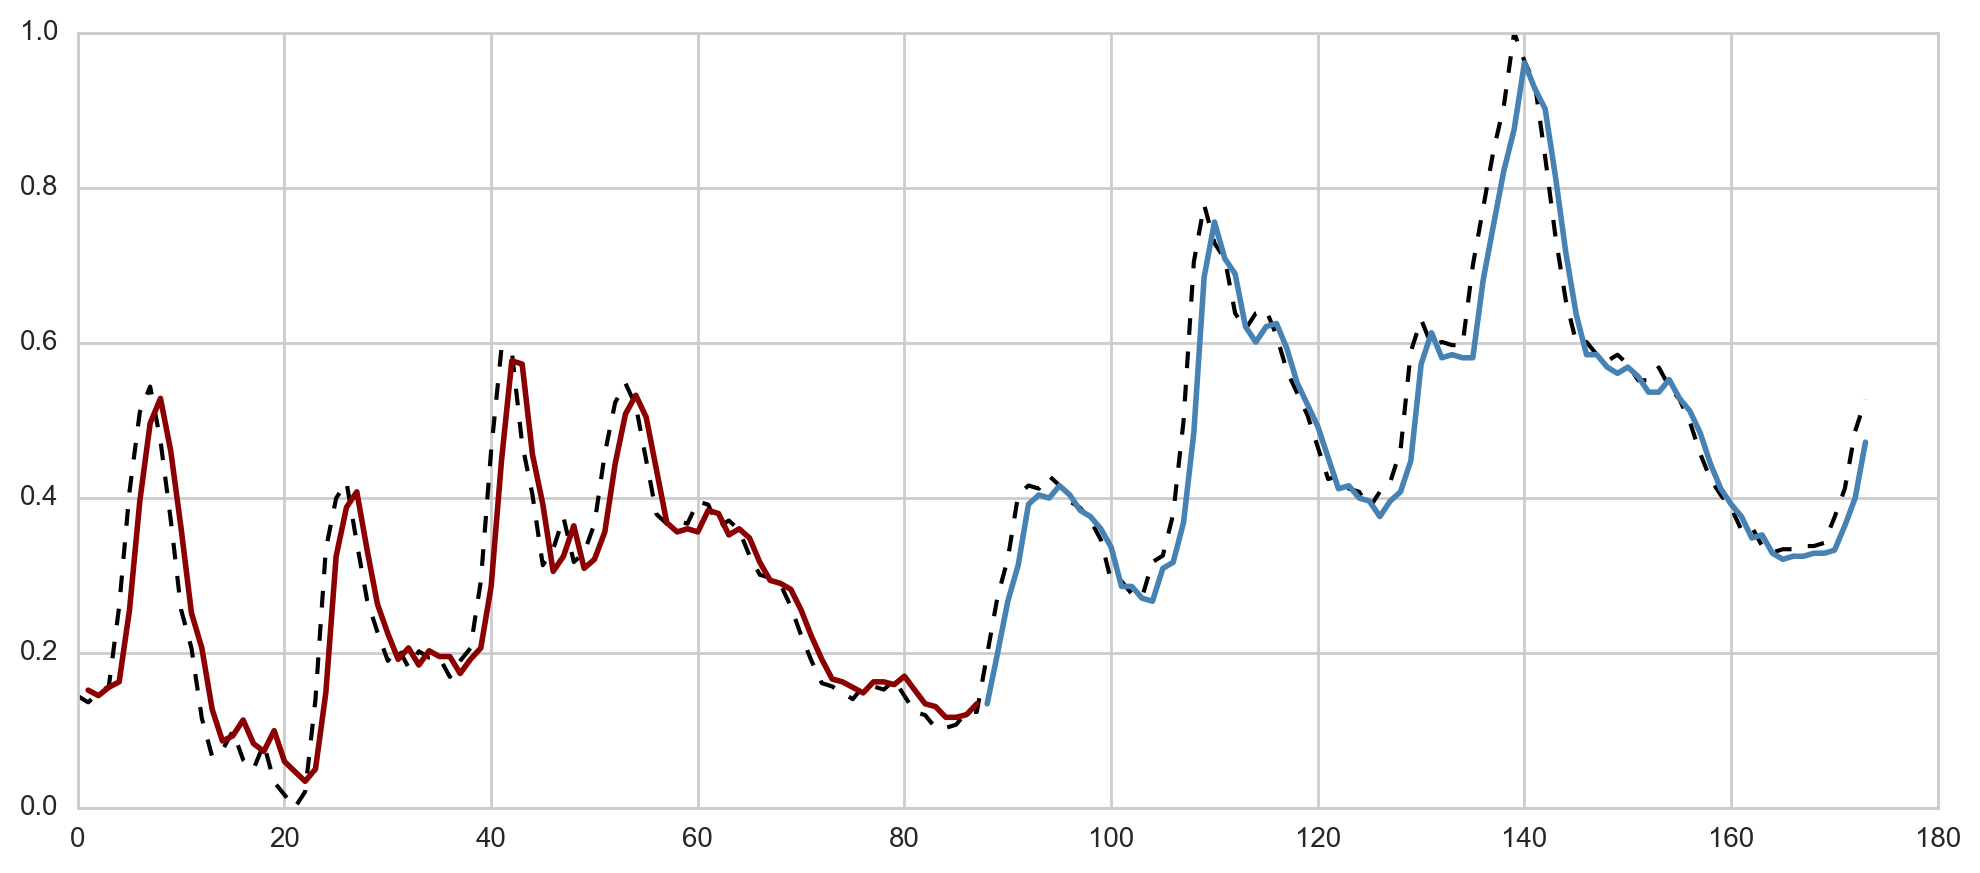

In [152]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(urate, lw=1.5, color='black', ls='dashed')
train_pred_plot = np.zeros(urate.shape)
train_pred_plot[:,:] = np.nan
train_pred_plot[1:(len(trainPredict)+1), :] = trainPredict

test_pred_plot = np.zeros(urate.shape)
test_pred_plot[:,:] = np.nan
test_pred_plot[(len(trainPredict)+1):, :] = testPredict

ax.plot(train_pred_plot, lw=2, color='darkred')
ax.plot(test_pred_plot, lw=2, color='steelblue')

plt.show()

results above are better than the results in original lab because we didn't lose a data point when we split. 

### LSTM with multiple lags as predictors

In [157]:
urateX, urateY = create_XY(urate, lag=3)

In [166]:
urateY = urateY.reshape(len(urateY), 1)

In [168]:
trainX, trainY = urateX[:urate.shape[0]/2, :], urateY[:urate.shape[0]/2,:]
testX, testY = urateX[urate.shape[0]/2:, :], urateY[urate.shape[0]/2:,:]

In [169]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [176]:
model = Sequential()
model.add(LSTM(12, input_dim=3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=50, batch_size=1, verbose=2)

Epoch 1/50
2s - loss: 0.0441
Epoch 2/50
0s - loss: 0.0142
Epoch 3/50
0s - loss: 0.0118
Epoch 4/50
0s - loss: 0.0107
Epoch 5/50
0s - loss: 0.0097
Epoch 6/50
0s - loss: 0.0089
Epoch 7/50
0s - loss: 0.0082
Epoch 8/50
0s - loss: 0.0076
Epoch 9/50
0s - loss: 0.0069
Epoch 10/50
0s - loss: 0.0064
Epoch 11/50
0s - loss: 0.0060
Epoch 12/50
0s - loss: 0.0056
Epoch 13/50
0s - loss: 0.0052
Epoch 14/50
0s - loss: 0.0050
Epoch 15/50
0s - loss: 0.0046
Epoch 16/50
0s - loss: 0.0044
Epoch 17/50
0s - loss: 0.0041
Epoch 18/50
0s - loss: 0.0039
Epoch 19/50
0s - loss: 0.0038
Epoch 20/50
0s - loss: 0.0035
Epoch 21/50
0s - loss: 0.0035
Epoch 22/50
0s - loss: 0.0033
Epoch 23/50
0s - loss: 0.0032
Epoch 24/50
0s - loss: 0.0031
Epoch 25/50
0s - loss: 0.0031
Epoch 26/50
0s - loss: 0.0030
Epoch 27/50
0s - loss: 0.0030
Epoch 28/50
0s - loss: 0.0028
Epoch 29/50
0s - loss: 0.0030
Epoch 30/50
0s - loss: 0.0028
Epoch 31/50
0s - loss: 0.0029
Epoch 32/50
0s - loss: 0.0029
Epoch 33/50
0s - loss: 0.0027
Epoch 34/50
0s - lo

### Plot Predictions of Model

In [177]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

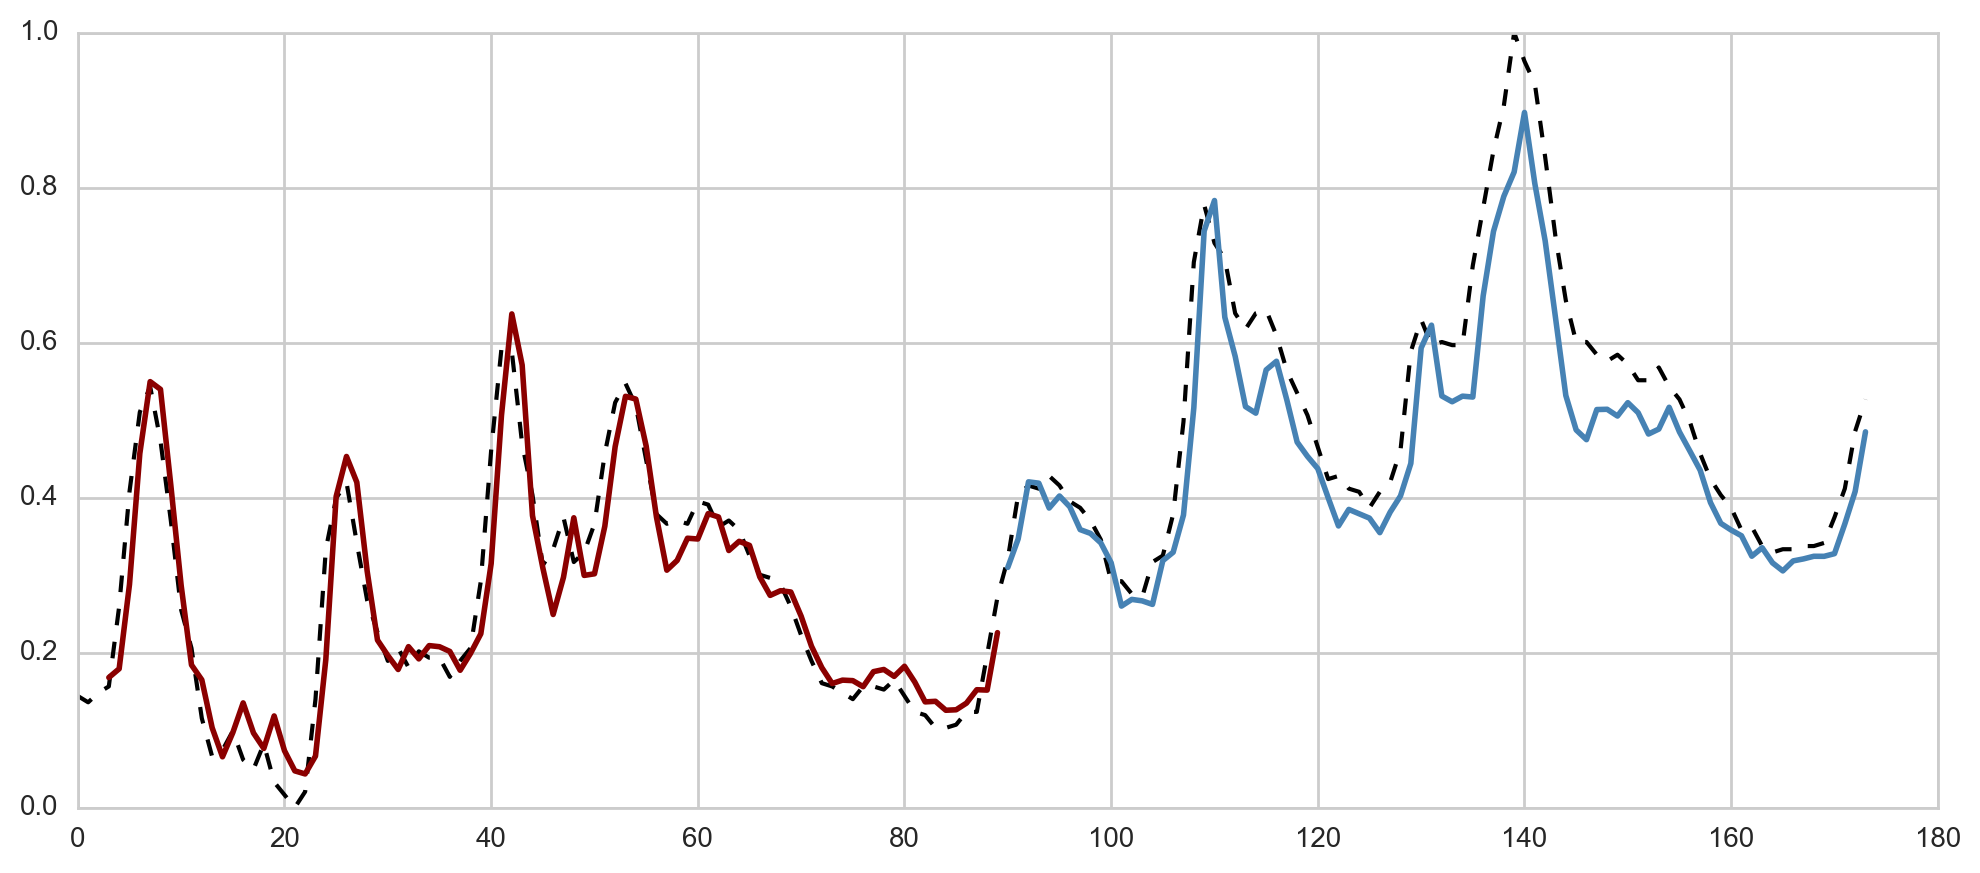

In [178]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(urate, lw=1.5, color='black', ls='dashed')
train_pred_plot = np.zeros(urate.shape)
train_pred_plot[:,:] = np.nan
train_pred_plot[3:(len(trainPredict)+3), :] = trainPredict

test_pred_plot = np.zeros(urate.shape)
test_pred_plot[:,:] = np.nan
test_pred_plot[(len(trainPredict)+3):, :] = testPredict

ax.plot(train_pred_plot, lw=2, color='darkred')
ax.plot(test_pred_plot, lw=2, color='steelblue')

plt.show()